### Desafio Ciência de Dados -  EDA e modelagem de banco de dados cinematográfico 🎥




O objetivo deste desafio é auxiliar a empresa PProductions na análise e no planejamento relacionados ao lançamento do seu novo filme, que em breve estará em cartaz. 


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from wordcloud import WordCloud
import joblib  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm


In [121]:
df = pd.read_csv("../data/raw/movies.csv")

In [61]:
df.head((3))

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [14]:
df.shape

(999, 16)

In [62]:
df.columns

Index(['Unnamed: 0', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [16]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [108]:
df.describe()

,Unnamed: 0,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,999.000000,842.000000,9.990000e+02
mean,500.000000,7.947948,77.969121,2.716214e+05
std,288.530761,0.272290,12.383257,3.209126e+05
min,1.000000,7.600000,28.000000,2.508800e+04
25%,250.500000,7.700000,70.000000,5.547150e+04
50%,500.000000,7.900000,79.000000,1.383560e+05
75%,749.500000,8.100000,87.000000,3.731675e+05
max,999.000000,9.200000,100.000000,2.303232e+06


In [122]:

#renomeando colunas 
df = df.rename(columns={ 'Series_Title': 'Title', 'Released_Year': 'Year', 'Certificate': 'Certificate','IMDB_Rating': 'Rating','No_of_Votes': 'Votes','Meta_score': 'scoreAvg','Gross': 'Revenue'}) 

In [123]:
#fazendo conversão de tipo e tratando caracteres
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
df['Certificate'] = df['Certificate'].astype('category')
df['Runtime'] = pd.to_numeric(df['Runtime'].str.replace(' min', '', regex=False), errors='coerce').astype('Int64')
df['scoreAvg'] = pd.to_numeric(df['scoreAvg'], errors='coerce').astype('Int64')
df['Revenue'] = pd.to_numeric(df['Revenue'].str.replace('$', '', regex=False).str.replace(',', '', regex=False), errors='coerce').astype('float64')

In [33]:
#verificando duplicatas
dups = df.duplicated().sum()
print(dups)


0


Dicionário de dados 

- `Title` - Nome do Filme 
- `Year`- Ano do filme 
- `Certificate` - Classificação etária
- `Runtime` – Tempo de duração
- `Genre` - Gênero
- `Rating` - Nota do IMDB
- `Overview` -  Comentarios sobre o filme
- `scoreAvg` - Média das criticas
- `Votes` - Qtd de votos 
- `Revenue` - Receita do filme





Foi gerado um relatório usando o pandas profiling com os dados iniciais, o arquivo está na pasta report

In [124]:
profile = ProfileReport(df, title="Movie Data Profiling Report", explorative=True)
profile.to_file("../reports/movies_data_raw_profiling_report_.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


#### Valores Faltantes

In [19]:

#valores faltantes
df.isnull().sum()

Unnamed: 0       0
Title            0
Year             1
Certificate    101
Runtime          0
Genre            0
Rating           0
Overview         0
scoreAvg       157
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
Votes            0
Revenue        169
dtype: int64

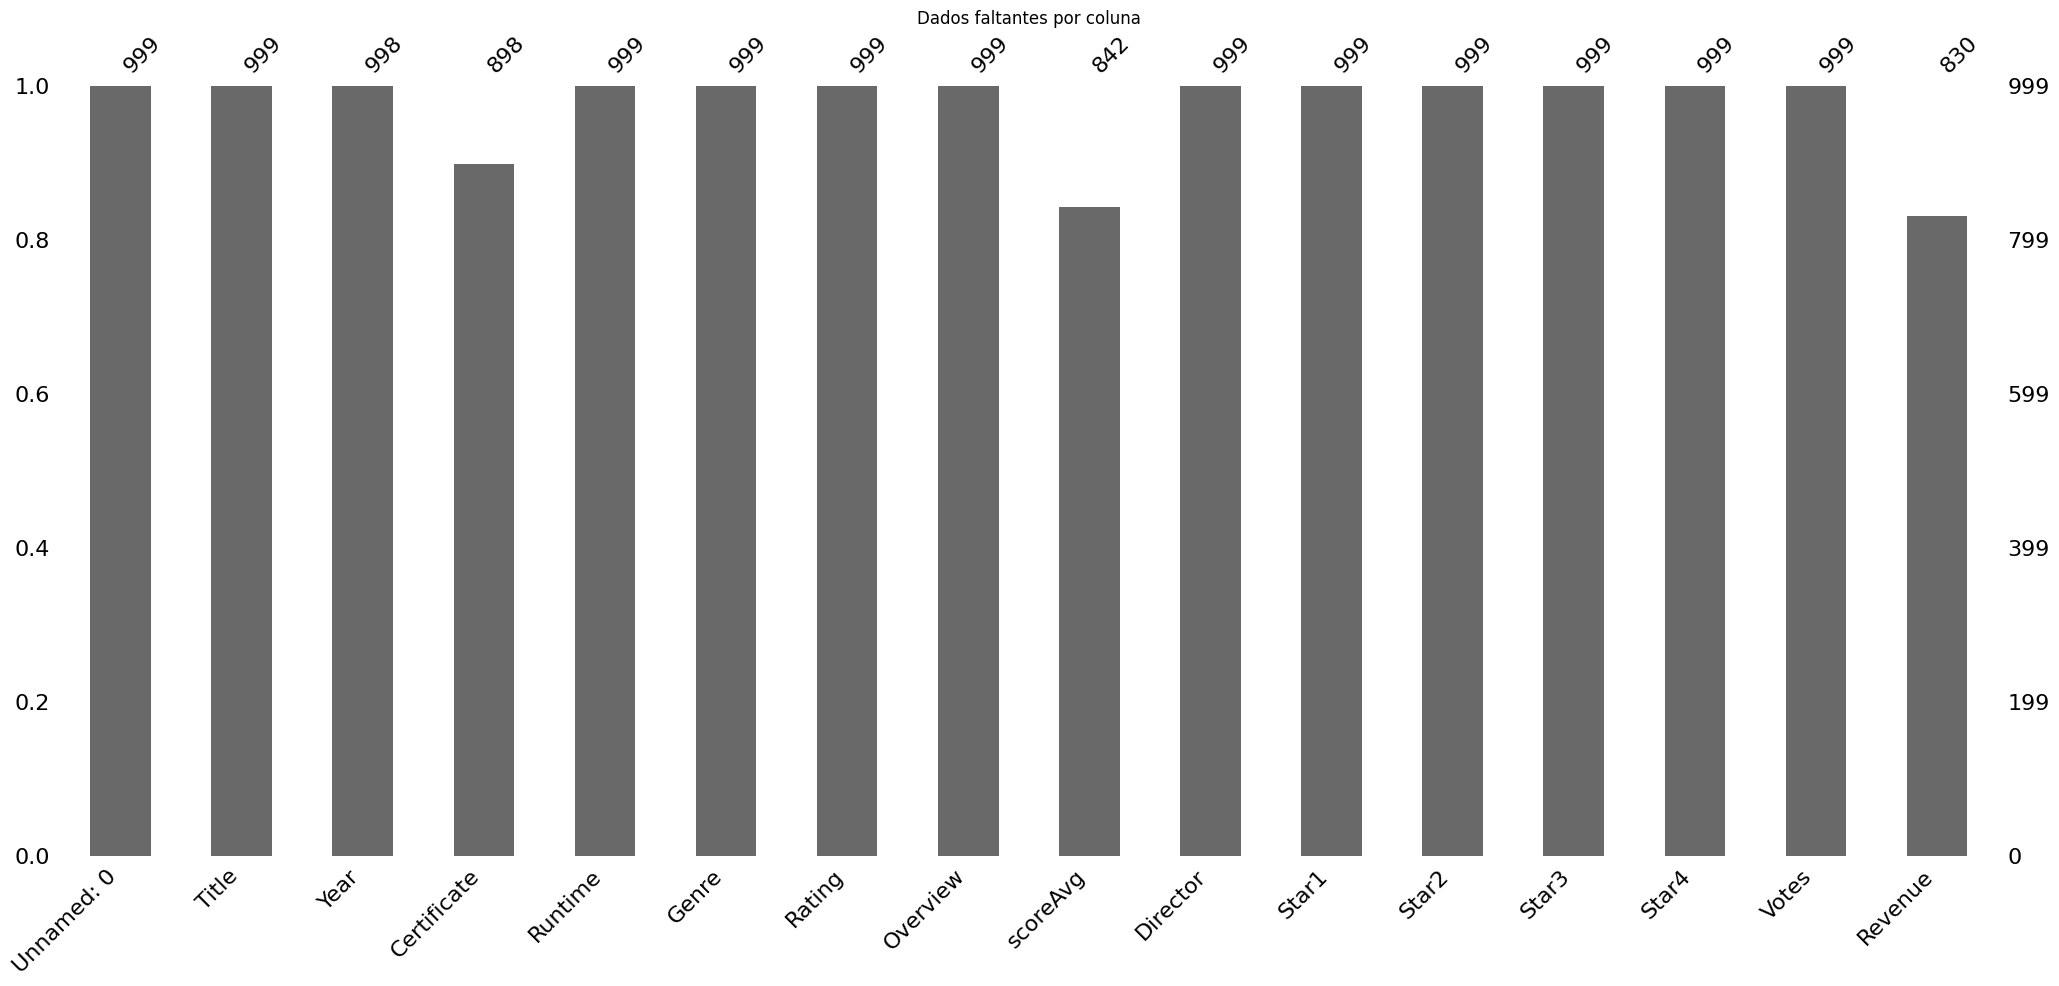

In [25]:
# plotando valores faltantes
plt.ion()  
plt.figure(figsize = (2,4))
msno.bar(df)
plt.title("Dados faltantes por coluna")
plt.show()

Os valores ausentes estão em  Certificate, scoreAvg e Revenue. Entre elas, a variável Revenue pode representar um desafio maior, pois está fortemente associada ao orçamento, ao marketing e à popularidade do filme, é uma variável essencial para a modelagem e pode impactar diretamente a qualidade das previsões.

#### Visão geral inicial dos dados 

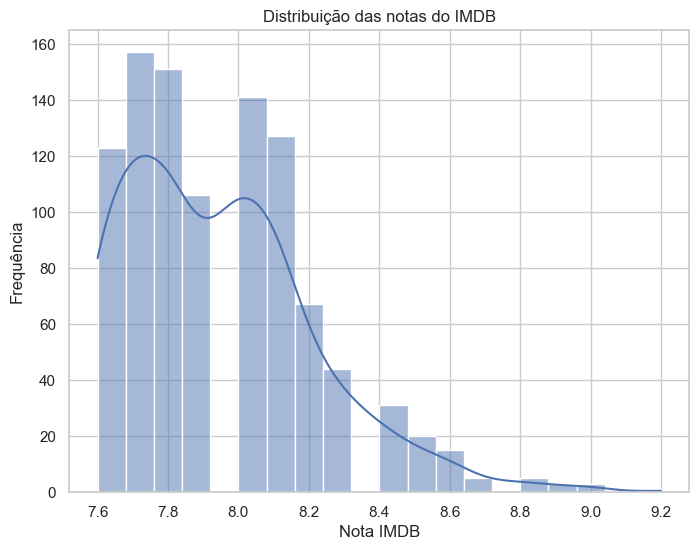

In [56]:
#plotando  histograma 
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Rating', bins=20, kde=True)
plt.title('Distribuição das notas do IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Frequência')
plt.show()

O gráfico apresentado ilustra como as avaliações do IMDB estão distribuídas; cada barra revela a quantidade de notas dentro de uma faixa específica. Observa-se um aumento notável nas notas entre 7.6 e 7.8, sugerindo que muitos filmes se concentram nessa área. A linha traçada é contínua, exibindo um leve prolongamento que destaca os filmes mais bem avaliados.

C:\Users\iarac\AppData\Local\Temp\ipykernel_14000\815973488.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='pastel')


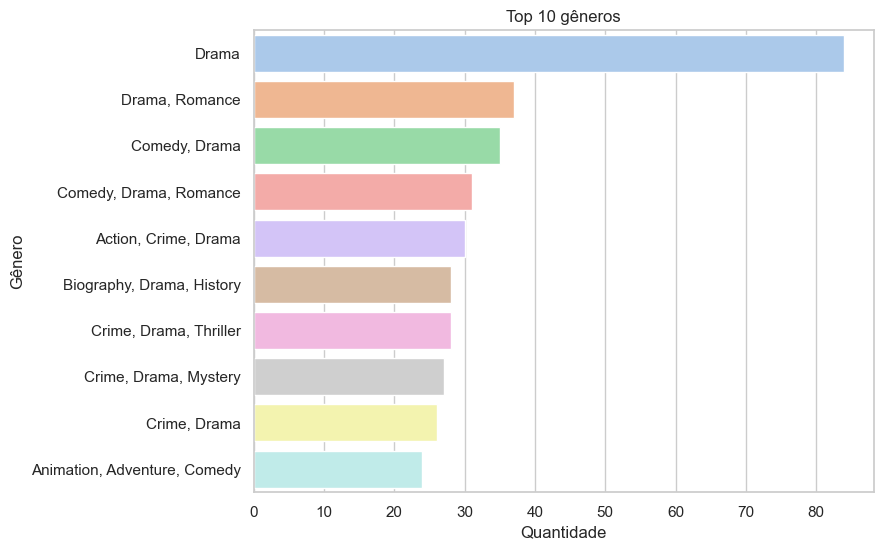

In [55]:
# plotando grafico com top generos
plt.figure(figsize=(8, 6))
genre_counts = df['Genre'].value_counts().head(10)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='pastel')
plt.title('Top 10 gêneros')
plt.xlabel('Quantidade')
plt.ylabel('Gênero')
plt.show()

O gráfico de barras mostra os 10 gêneros mais frequentes no BD, podemos observar que o gênero drama aparece com frequência, ele possui mais de 80 ocorrências, tanto isoladamente quanto em combinações com outros gêneros como Romance, Comedy e Crime. Ou seja, o modelo será capaz de aprender padrões e generalizar a previsão da bilheteria de filmes mais dramáticos. Além disso, a presença de Animation, Adventure e Comedy sugere filmes voltados para um  público mais familiar, mostrando que esse tipo de produção também tem destaque nas avaliações. 

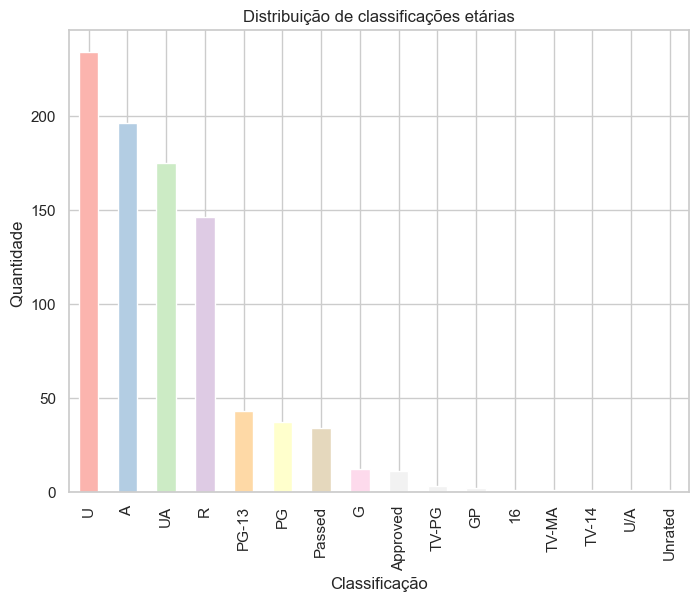

In [58]:
#plotando grafico com classificaçoes etarias
plt.figure(figsize=(8, 6))
df['Certificate'].value_counts().plot(kind='bar', color=plt.cm.Pastel1(range(len(df['Certificate'].value_counts()))))
plt.title('Distribuição de classificações etárias')
plt.xlabel('Classificação')
plt.ylabel('Quantidade ')
plt.show()

O gráfico revela como as faixas etárias dos filmes se espalham pelo BD. As categorias "Livre", "A" e "UA" são as mais comuns, mostrando que a maioria dos filmes visa o público de todas as idades, ou o jovem.

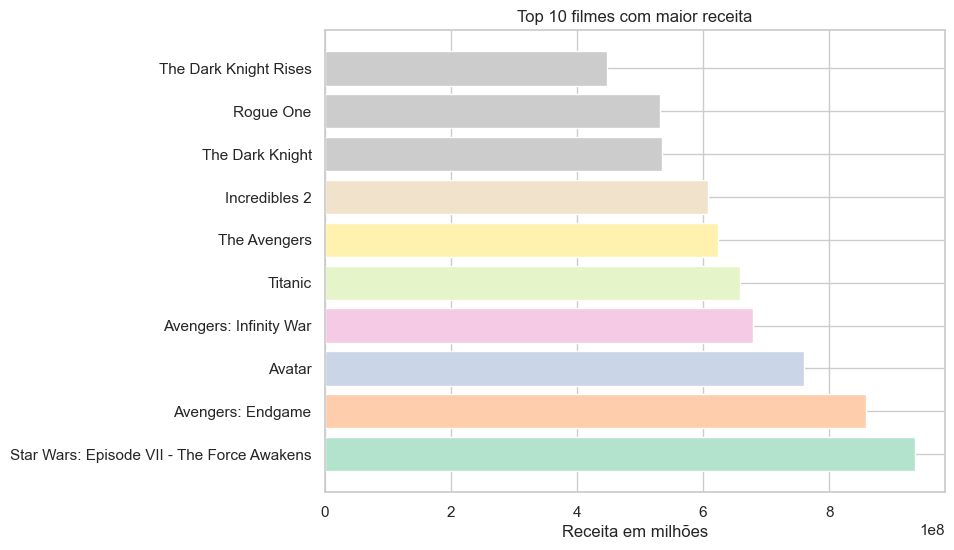

In [82]:
plt.figure(figsize=(8, 6))
top_revenue = df.nlargest(10, 'Revenue')[['Title', 'Revenue']]
plt.barh(top_revenue['Title'], top_revenue['Revenue'], color=plt.cm.Pastel2(range(10)))
plt.title('Top 10 filmes com maior receita')
plt.xlabel('Receita em milhões')
plt.show()

O gráfico apresenta os 10 filmes com maior receita do BD: 

- No topo do ranking está "Star Wars: Episódio VII - O Despertar da Força", campeão de vendas, com "Vingadores: Ultimato" e "Avatar" logo em seguida.

- Produções de peso da Marvel e DC, como (Vingadores, Os Vingadores, Vingadores: Guerra Infinita, Os Incríveis 2) e Batman (O Cavaleiro das Trevas, O Cavaleiro das Trevas Ressurge), figuram entre os maiores sucessos de bilheteria.

- Clássicos atemporais como "Titanic" também marcam presença, provando que tanto novidades quanto obras já consagradas podem alcançar grande sucesso comercial.

- A distância no faturamento entre o líder e os demais filmes na lista é bem grande, mostrando um contraste marcante no desempenho financeiro entre os 10 filmes.



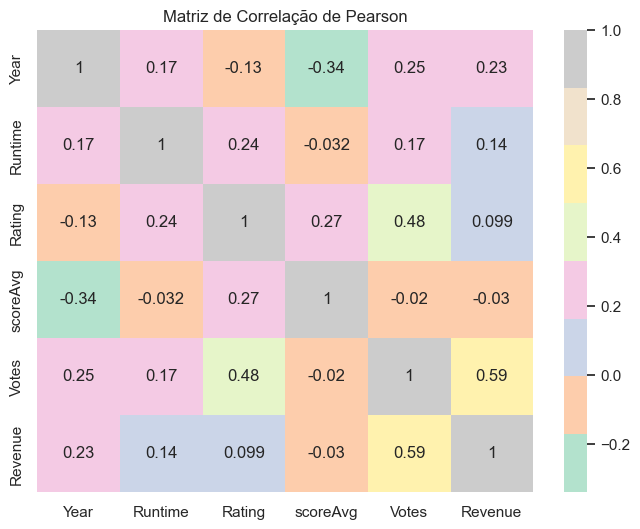

In [80]:
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(columns=['Unnamed: 0'])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='Pastel2')
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### Correlação entre dados numéricos

A análise da matriz de correlação de Pearson revela as interações entre as variáveis quantitativas:

- Votos e Receita: observa-se uma relação positiva razoável (0.59), sugerindo que filmes com maior número de votos costumam ter maior faturamento.

- Avaliação e Votos: existe uma ligação positiva considerável (0.48), o que pode indicar que filmes com mais votos tendem a ter avaliações melhores.

- Nota Média: demonstra uma relação tênue com as outras variáveis, o que sinaliza que a nota média não é muito influenciada pelo ano, duração ou receita.

- Ano e Receita/Votos: filmes lançados recentemente parecem ter mais votos e gerar mais receita, apesar da relação não ser forte nem totalmente desprezível.

- Duração: não demonstra grande impacto linear sobre Avaliação, Votos ou Receita.

#### Árvore de Decisão 

Para verificar o quão boas eram as previsões usamos a árvore de decisão regressora. Com essa estratégia, é possivel enxergar como os dados se comportam a priori

In [114]:
#clona repositorio
df_clone = df.copy(deep=True)

#tratando valores faltantes
df_clone['scoreAvg'] = df_clone['scoreAvg'].fillna(df_clone['scoreAvg'].median())
df_clone['Revenue'] = df_clone['Revenue'].fillna(df_clone['Revenue'].median())

#escolhendo var numericas
features = ['Runtime', 'scoreAvg', 'Votes', 'Revenue']
X = df[features]
y = df['Rating']

#dividindo dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#treinando modelo de regressão
model = DecisionTreeRegressor(random_state=42, max_depth=3)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

r2_score(y_test, predictions)
print(f"R² Score: {r2_score(y_test, predictions)}")

#salva modelo
joblib.dump(model, "../models/decision_tree_model.pkl")


R² Score: 0.23472024330123342


['../models/decision_tree_model.pkl']

#### Novos Dados do TMDB

Após examinar as relações entre os dados e usar o algoritmo de árvore de decisão, ficou claro que era preciso aprimorar a base de dados. Assim, dados do TMDB (The Movie Database), foram obtidos através da sua API, e integrados ao dataframe para completar os dados já existentes e auxiliar nos insights e modelagem.

**TMDB (The Movie Database)** é uma base de dados gratuita sobre cinema, que fornece informações detalhadas sobre filmes, incluindo receita, orçamento, popularidade e avaliações. Link da API: (https://www.themoviedb.org/). 



**Colunas novas:**
- `tmdb_revenue`: Receita global  
- `tmdb_budget`: Orçamento de produção  
- `tmdb_popularity`: Popularidade do filme  
- `tmdb_vote_count`: Número de votos no TMDB  
- `tmdb_vote_average`: Nota média no TMDB  




In [125]:
df = pd.read_csv("../data/processed/movies_with_tmdb.csv")

In [102]:
df.head((3))


,Unnamed: 0.1,Unnamed: 0,Title,Year,Certificate,Runtime,Genre,Rating,Overview,scoreAvg,...,Star1,Star2,Star3,Star4,Votes,Revenue,tmdb_budget,tmdb_popularity,tmdb_vote_count,tmdb_revenue
0,0,1,The Godfather,1972.0,A,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,...,Marlon Brando,Marlon Brando,Marlon Brando,Marlon Brando,1620367,134966411.0,6000000.0,24.7742,21774.0,2.450664e+08
1,1,2,The Dark Knight,2008.0,UA,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,...,Christian Bale,Christian Bale,Christian Bale,Christian Bale,2303232,534858444.0,185000000.0,27.8211,34305.0,1.004558e+09
2,2,3,The Godfather: Part II,1974.0,A,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,...,Al Pacino,Al Pacino,Al Pacino,Al Pacino,1129952,57300000.0,13000000.0,16.7095,13147.0,1.026000e+08


In [137]:
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)   

In [134]:
df.shape


(999, 21)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            999 non-null    object 
 1   Year             998 non-null    float64
 2   Certificate      898 non-null    object 
 3   Runtime          999 non-null    float64
 4   Genre            999 non-null    object 
 5   Rating           999 non-null    float64
 6   Overview         999 non-null    object 
 7   scoreAvg         842 non-null    float64
 8   Director         999 non-null    object 
 9   Star1            999 non-null    object 
 10  Star2            999 non-null    object 
 11  Star3            999 non-null    object 
 12  Star4            999 non-null    object 
 13  Votes            999 non-null    int64  
 14  Revenue          830 non-null    float64
 15  tmdb_budget      993 non-null    float64
 16  tmdb_popularity  993 non-null    float64
 17  tmdb_vote_count 

Os dados obtidos pela API já estão no tipo correto.

In [105]:
df.describe()

,Year,Runtime,Rating,scoreAvg,Votes,Revenue,tmdb_budget,tmdb_popularity,tmdb_vote_count,tmdb_revenue
count,998.000000,999.000000,999.000000,842.000000,9.990000e+02,8.300000e+02,9.930000e+02,993.000000,993.000000,9.930000e+02
mean,1991.214429,122.871872,7.947948,77.969121,2.716214e+05,6.808257e+07,2.583902e+07,6.223619,5496.417925,1.366857e+08
std,23.308539,28.101227,0.272290,12.383257,3.209126e+05,1.098076e+08,4.712061e+07,5.444405,6537.642431,2.755679e+08
min,1920.000000,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,0.000000e+00,0.009600,0.000000,0.000000e+00
25%,1976.000000,103.000000,7.700000,70.000000,5.547150e+04,3.245338e+06,1.255000e+06,2.658800,1033.000000,4.396821e+06
50%,1999.000000,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07,6.900000e+06,4.330800,2582.000000,3.150000e+07
75%,2009.000000,137.000000,8.100000,87.000000,3.731675e+05,8.087634e+07,2.500000e+07,7.944000,7816.000000,1.249000e+08
max,2020.000000,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,3.560000e+08,48.757200,37863.000000,2.923706e+09


In [112]:
#verificando duplicatas
dups = df.duplicated().sum()
print(dups)

0


In [111]:

#valores faltantes
df.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0           0
Title                0
Year                 1
Certificate        101
Runtime              0
Genre                0
Rating               0
Overview             0
scoreAvg           157
Director             0
Star1                0
Star2                0
Star3                0
Star4                0
Votes                0
Revenue            169
tmdb_budget          6
tmdb_popularity      6
tmdb_vote_count      6
tmdb_revenue         6
dtype: int64

Dicionário de dados 

- `Title` - Nome do Filme 
- `Year`- Ano do filme 
- `Certificate` - Classificação etária
- `Runtime` – Tempo de duração
- `Genre` - Gênero
- `Rating` - Nota do IMDB
- `Overview` -  Comentarios sobre o filme
- `scoreAvg` - Média das criticas
- `Votes` - Qtd de votos 
- `Revenue` - Receita do filme
- `tmdb_revenue`: Receita global  
- `tmdb_budget`: Orçamento de produção  
- `tmdb_popularity`: Popularidade do filme  
- `tmdb_vote_count`: Número de votos no TMDB  
- `tmdb_vote_average`: Nota média no TMDB  





Foi gerado um relatório usando o pandas profiling com os novos dado, o arquivo está na pasta report. Esses relatórios auxiliaram nas outras análises.

In [126]:
profile = ProfileReport(df, title="Movie Data Profiling Report", explorative=True)
profile.to_file("../reports/movies_data_with_tmbd_profiling_report_.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


#### Análise comparativa das receitas 



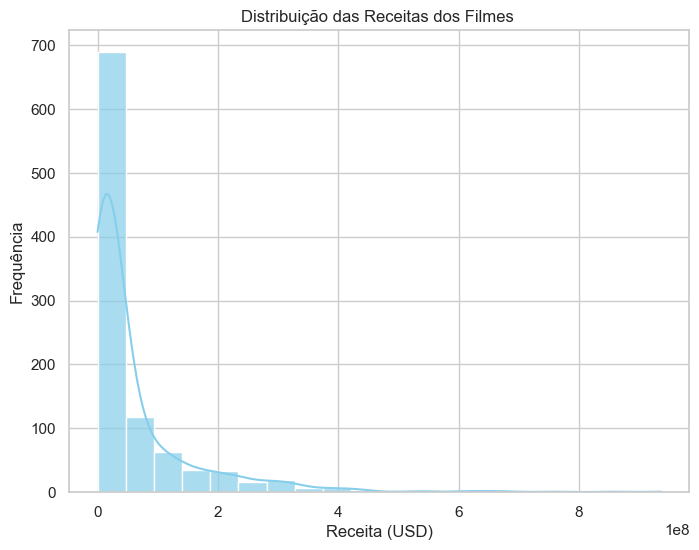

In [130]:
# plotando histograma das receitas 

plt.figure(figsize=(8, 6))
sns.histplot(data=df_clone, x='Revenue', bins=20, kde=True, 
             color='#87CEEB', edgecolor='white', alpha=0.7)
plt.title('Distribuição das Receitas dos Filmes ')
plt.xlabel('Receita (USD)')
plt.ylabel('Frequência')
plt.show()

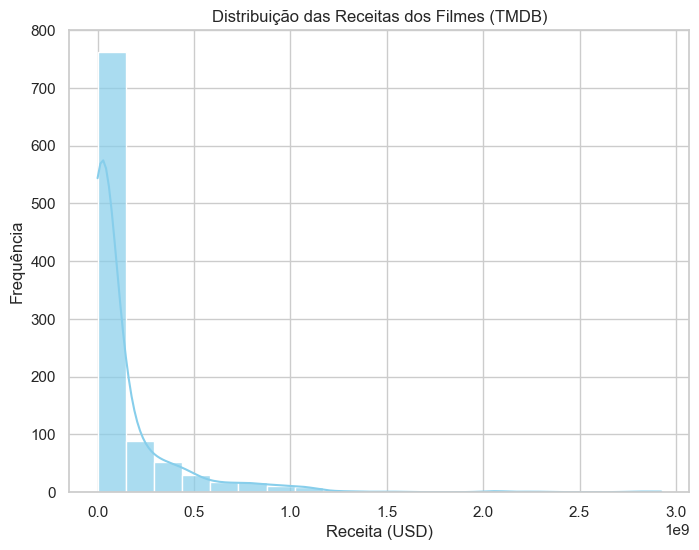

In [129]:


# plotando histograma das receitas do TMDB

plt.figure(figsize=(8, 6))
sns.histplot(data=df_clone, x='tmdb_revenue', bins=20, kde=True, 
             color='#87CEEB', edgecolor='white', alpha=0.7)
plt.title('Distribuição das Receitas dos Filmes (TMDB)')
plt.xlabel('Receita (USD)')
plt.ylabel('Frequência')
plt.show()

In [131]:
correlation = df['Revenue'].corr(df_clone['tmdb_revenue'])
print(f"Correlação entre Receita Original e TMDB: {correlation:.4f}")

Correlação entre Receita Original e TMDB: 0.9470


In [133]:

df_diff = ((df_clone['tmdb_revenue'] - df['Revenue']) / df['Revenue']) * 100

print(df_diff.head())

mean_diff = df_diff.mean()
print(f"Diferença percentual média: {mean_diff:.2f}%")


0     81.575852
1     87.817628
2     79.057592
3      0.000000
4    196.123093
dtype: float64
Diferença percentual média: 2280.37%


No conjunto de dados inicial, notamos a ausência de 169 valores na coluna referente à receita. Para tentar preencher essas lacunas, buscamos informações complementares na base de dados de receitas do MDB (The Movie Database).

Ao comparar as receitas originais com os dados do TMDB, encontramos uma forte relação de 0.9470, o que sugere uma concordância geral entre as fontes. Apesar disso, observamos que a variação percentual entre os valores é considerável em certas situações, o que poderia causar problemas se substituíssemos os dados originais pelos do TMDB. De qualquer forma a coluna tmdb_revenue será mantida. 

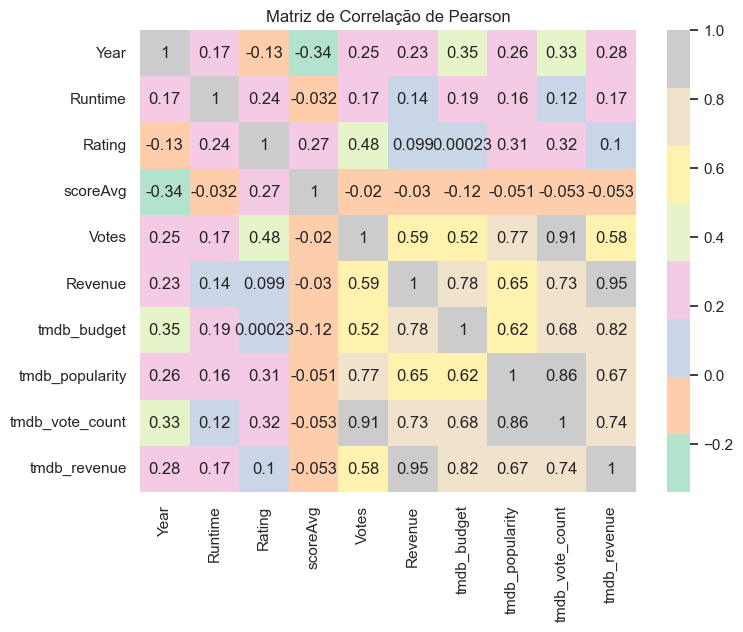

In [138]:
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='Pastel2')
plt.title('Matriz de Correlação de Pearson')
plt.show()

#### Correlação/ Insights sobre os novos dados 


Existe uma ligação clara entre a receita de um filme e o número de votos que ele recebe (0.603), assim como o tmdb_budget/orçamento investido  (0.783).

De modo geral, longas-metragens com orçamentos mais robustos e que despertam maior interesse do público tendem a ter uma bilheteria maior.

A popularidade de um filme antes de seu lançamento tem uma relação positiva razoável com sua receita (0.657), o que indica que essa popularidade impacta diretamente o quanto o filme arrecada.

Há uma forte conexão entre a popularidade de um filme e a quantidade de votos que ele recebe (0.770), mostrando que filmes mais conhecidos atraem mais votos, o que enfatiza a importância da visibilidade.

O orçamento de um filme está muito ligado à sua receita (0.783) e a quantidade de votos que recebe na plataforma TMDB (0.523).

Isso sugere que filmes com orçamentos maiores ganham mais atenção e, consequentemente, geram um retorno financeiro mais elevado.

Existe uma correlação positiva (0.770) entre a quantidade de avaliações que um filme recebe no TMDB e a receita que ele gera, o que reforça o impacto do envolvimento do público.

#### Hipóteses entre receita e filme


##### **Orçamento influencia diretamente na receita**

Hipótese: filmes com orçamento maior (tmdb_budget) tendem a gerar maior receita (Revenue e tmdb_revenue). A justificativa é que mais verba permite uma produção superior, com efeitos visuais mais impressionantes, atores famosos e ações de marketing mais eficientes.

#####  **Análise:** 

- Qualidade da produção

Grandes somas viabilizam a contratação de diretores, atores e técnicos renomados, equipamentos de ponta e cenários sofisticados, o que eleva a percepção de valor do filme e atrai mais espectadores.

- Marketing e divulgação

Filmes com orçamentos generosos normalmente contam com campanhas de marketing extensas, incluindo trailers em diversas mídias, colaborações e produtos licenciados, aumentando a visibilidade e o interesse do público.

- Distribuição e alcance

Mais recursos permitem o lançamento em mais salas de cinema, tanto no país quanto no exterior, elevando o potencial de bilheteria.

- Relação entre dados

A correlação de 0.783 entre tmdb_budget e Revenue demonstra uma forte relação positiva: à medida que o orçamento aumenta, a receita também tende a crescer.

Isso indica que o orçamento é um dos fatores cruciais para o êxito financeiro do filme, embora não seja o único, já que outros aspectos como gênero, popularidade antes do lançamento e críticas também são importantes.

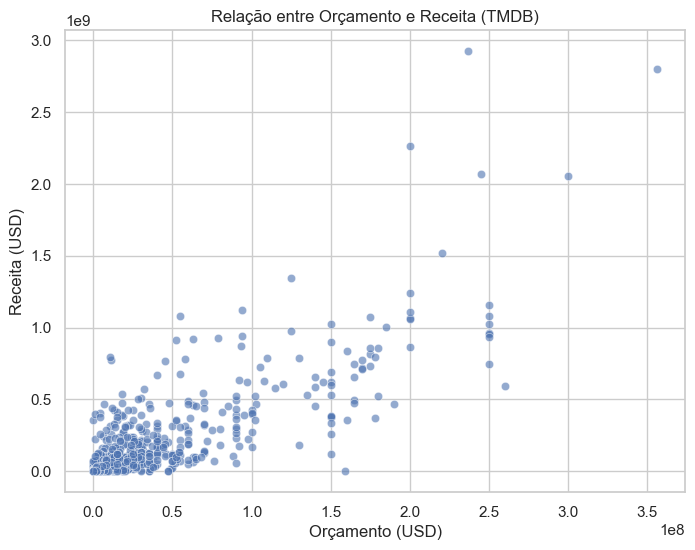

In [142]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='tmdb_budget', y='tmdb_revenue', data=df, alpha=0.6)
plt.title('Relação entre Orçamento e Receita (TMDB)')
plt.xlabel('Orçamento (USD)')
plt.ylabel('Receita (USD)')
plt.show()


Ao analisar o diagrama de dispersão, observa-se uma ligação positiva evidente entre o valor investido e o faturamento dos filmes. Isso sugere que obras cinematográficas com orçamentos mais robustos geralmente arrecadam quantias maiores. Contudo, essa relação não é direta, notando-se uma variação considerável, principalmente em projetos de custo elevado. Alguns filmes alcançam ganhos extraordinários, enquanto outros têm um retorno financeiro mais discreto. Isso demonstra que elementos além do orçamento , como qualidade do filme, as estratégias de marketing ou a popularidade junto ao público, exercem um papel essencial no sucesso financeiro. A maior parte dos filmes concentra-se na faixa de orçamento baixo e receita moderada, o que confirma que a indústria cinematográfica funciona, em sua maioria, com produções de menor risco, mas também com um potencial restrito de gerar retornos excepcionais.

#### Hipóteses entre Gênero e receita


##### **Gênero influencia diretamente na receita**

Hipótese: Filmes de gêneros como Ação, Aventura e Ficção Científica tendem a gerar maior receita (Revenue e tmdb_revenue) em comparação com outros gêneros. A justificativa é q é que esses gêneros chamam mais atenção do público, têm mais chances de virar franquias e atraem gente ao redor do mundo.  O  dataset apresentando possui uma predominância de filmes de Drama, mas em bilheteriais dos gêneros Ação e Aventura geralmente são superiores.

 **Análise:**

- Apelo comercial e demográfico
Filmes como Ação, Aventura e Ficção Científica fazem sucesso em vários países, atraindo pessoas de diferentes idades e culturas. Esses filmes geralmente têm efeitos visuais incríveis, que chamam a atenção do público. 

- Franquias e produtos
Gêneros com alta capacidade de geração de receita costumam virar franquias, sequências e produtos licenciados (brinquedos, jogos, roupas), que aumentam a popularidade e nota.


- Experiência coletiva
Gêneros como Ação e Aventura criam eventos culturais que incentivam a experiência coletivas no cinema, diferentemente dos genêros que envolvem drama. Isso impulsiona a popularidade dos filmes


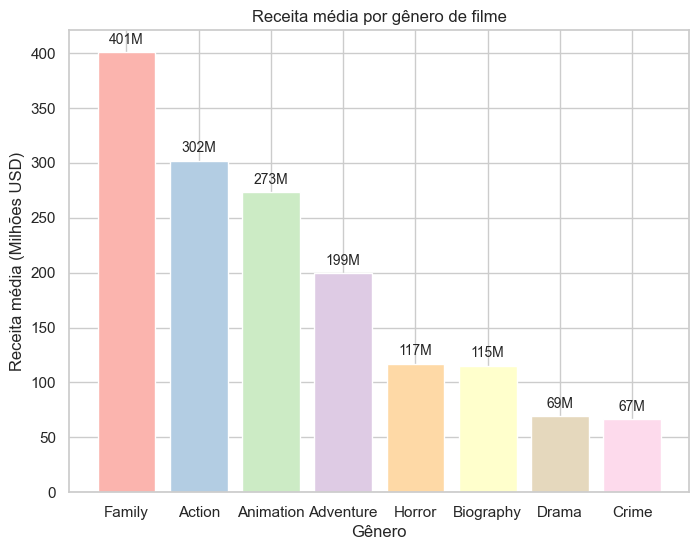

In [158]:

df['Primary_Genre'] = df['Genre'].str.split(',').str[0].str.strip()

revenue_genre= df.groupby('Primary_Genre')['tmdb_revenue'].mean() / 1e6 
revenue_genre= revenue_genre.sort_values(ascending=False).head(8) 

plt.figure(figsize=(8, 6))
bars = plt.bar(revenue_genre.index, revenue_genre.values, color=plt.cm.Pastel1(range(len(revenue_genre))))

plt.title('Receita média por gênero de filme', fontsize=12 )
plt.ylabel('Receita média (Milhões USD)', fontsize=12)
plt.xlabel('Gênero', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.0f}M', ha='center', va='bottom', fontsize=10)
plt.show()

A análise visual dos dados sugere que filmes de Ação e Aventura tendem a ter um desempenho financeiro médio melhor. Tais categorias, muitas vezes combinadas com Animação e Família, alcançam um público global mais amplo e abrem caminho criação de franquias. 

#### Insights sobre a coluna Overview

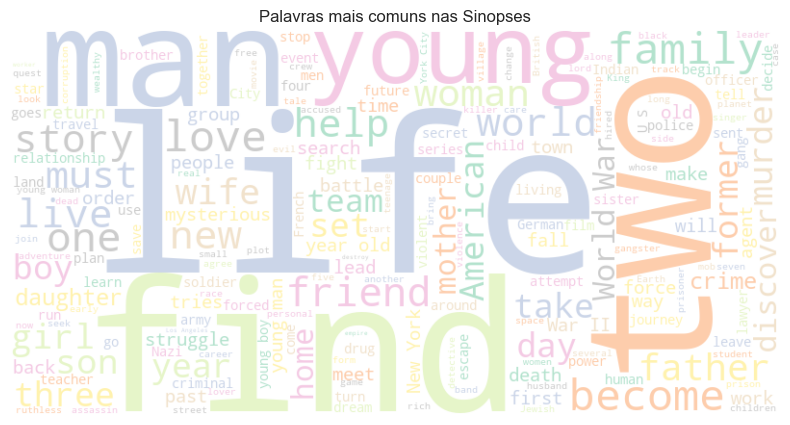

In [159]:
#plotando nuvem de palavras 
text = ' '.join(df['Overview'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Pastel2').generate(text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais comuns nas sinopses')
plt.show()

Ao examinar os termos que mais se repetem nas sinopses de filmes, existem algumas tendências: 

- Termos como "homem", "jovem" e "vida" denotam um acento em tramas sobre crescimento e evolução individual.

- "Amigo", "amor", "ajuda" e "família" indicam a importância das relações interpessoais.

- As histórias sempre ressaltam laços afetivos, isso cativa o público.

- "Tempo", "futuro" e "Guerra Mundial" expõem um interesse em cenários históricos e interesse em obras futuristicas. 


In [165]:

# transformar string de gêneros em lista
df['genres_list'] = df['Genre'].apply(lambda s: [g.strip() for g in str(s).split(',') if g.strip()])

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['genres_list'])

# TF-IDF
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=5)
X = tfidf.fit_transform(df['Overview'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y.sum(axis=1))

clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("Micro F1:", f1_score(y_val, y_pred, average='micro'))
print(classification_report(y_val, y_pred, target_names=mlb.classes_))
joblib.dump({"tfidf": tfidf, "clf": clf, "mlb": mlb}, "../models/genre_components.pkl")


Micro F1: 0.4090267983074753
              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        37
   Adventure       1.00      0.06      0.11        36
   Animation       0.00      0.00      0.00        18
   Biography       0.50      0.06      0.11        17
      Comedy       0.00      0.00      0.00        55
       Crime       0.00      0.00      0.00        46
       Drama       0.72      0.99      0.84       144
      Family       0.00      0.00      0.00        13
     Fantasy       0.00      0.00      0.00        12
   Film-Noir       0.00      0.00      0.00         7
     History       0.00      0.00      0.00         8
      Horror       0.00      0.00      0.00         8
       Music       0.00      0.00      0.00         7
     Musical       0.00      0.00      0.00         4
     Mystery       0.00      0.00      0.00        22
     Romance       0.00      0.00      0.00        27
      Sci-Fi       0.00      0.00      0.00        1

c:\Users\iarac\OneDrive\Área de Trabalho\LH_CD_IARA_CAMPOS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\iarac\OneDrive\Área de Trabalho\LH_CD_IARA_CAMPOS\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


['../models/genre_components.pkl']

##### Insights extraídos da coluna Overview

A seção de sinopse(Overview) oferece pistas textuais valiosas: extensão, léxico particular, atmosfera emocional e construções semânticas que auxiliam na definição de gêneros e subgêneros.

Em testes com TF-IDF + OneVsRest, o modelo mostrou micro F1 = 0.409, indicando sinal útil, mas forte viés para Drama e baixa capacidade de distinguir gêneros menos frequentes.



- Tamanho do texto (n_words)

Overviews mais são dos genêros Drama e Biography

- Overviews muito curtos são comuns em Comedy, Action e gêneros não rotulados. 

- Palavras-chave / n-grams

Tokens discriminativos observados:

Romance: love, relationship, romantic

Crime/Thriller: murder, detective, investigation

Sci-Fi: space, alien, planet


- Tom / Sentimento

Overviews com tom mais negativo/sombrio tem a ver com Horror e Thriller.

Overviews emocionais/positivos aparecem mais em Romance e Family.






In [174]:

df_encoded = df.copy()


director_encoder = TargetEncoder(smoothing=2.0)
df_encoded['Director_encoded'] = director_encoder.fit_transform(df_encoded['Director'], df_encoded['Rating'])


genre_encoder = TargetEncoder(smoothing=1.0)
df_encoded['Genre_encoded'] = genre_encoder.fit_transform(df_encoded['Genre'], df_encoded['Rating'])


for i in range(1, 5):
    freq = df_encoded[f'Star{i}'].value_counts()
    df_encoded[f'Star{i}_freq'] = df_encoded[f'Star{i}'].map(freq)


certificate_encoder = LabelEncoder()
df_encoded['Certificate_encoded'] = certificate_encoder.fit_transform(df_encoded['Certificate'].fillna('Unknown'))

top_certificates = df_encoded['Certificate'].value_counts().head(5).index
for cert in top_certificates:
    df_encoded[f'Cert_{cert}'] = (df_encoded['Certificate'] == cert).astype(int)


df_encoded['Overview'] = df_encoded['Overview'].fillna('')


tfidf = TfidfVectorizer(max_features=50, stop_words='english')  #limitando ate 50
overview_tfidf = tfidf.fit_transform(df_encoded['Overview'])
overview_features = pd.DataFrame(overview_tfidf.toarray(), 
                                columns=[f'overview_{i}' for i in range(overview_tfidf.shape[1])])


df_encoded = pd.concat([df_encoded, overview_features], axis=1)

numeric_cols = ['Year', 'Runtime', 'scoreAvg', 'Revenue', 'tmdb_budget', 
                'tmdb_popularity', 'tmdb_vote_count', 'tmdb_revenue']

for col in numeric_cols:
    if col in df_encoded.columns:
        df_encoded[col] = df_encoded[col].fillna(df_encoded[col].median())


cols_to_drop = ['Title', 'Director', 'Genre', 'Star1', 'Star2', 'Star3', 'Star4', 'Certificate', 'Overview']
df_encoded = df_encoded.drop(columns=[col for col in cols_to_drop if col in df_encoded.columns])

print(df_encoded.info())
print("\nPrimeiras linhas do dataframe transformado:")
print(df_encoded.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 999 non-null    float64
 1   Runtime              999 non-null    float64
 2   Rating               999 non-null    float64
 3   scoreAvg             999 non-null    float64
 4   Votes                999 non-null    int64  
 5   Revenue              999 non-null    float64
 6   tmdb_budget          999 non-null    float64
 7   tmdb_popularity      999 non-null    float64
 8   tmdb_vote_count      999 non-null    float64
 9   tmdb_revenue         999 non-null    float64
 10  Primary_Genre        999 non-null    object 
 11  genres_list          999 non-null    object 
 12  Director_encoded     999 non-null    float64
 13  Genre_encoded        999 non-null    float64
 14  Star1_encoded        999 non-null    float64
 15  Star2_encoded        999 non-null    flo



 ##### Decisões de Encoding

- Director

    Utilizamos Target Encoding  porque a coluna contém muitos valores distintos, a técnica substitui cada diretor pela média da variável alvo (`Rating`). 

- Genre (Target Encoding)

    Como gêneros também podem ser bastante variados, tambem usa-se o Target Encoding que captura a correlação direta entre o gênero e a nota (`Rating`).

- Stars 

   As colunas `Star1` a `Star4` foram transformadas em  Frequency Encoding, mapeando cada ator pelo número de vezes que aparece no dataset. Usamos só duas variaveis para reduzir a dimensionalidade
   

 - Certificate Label Encoding  One-Hot parcial

    Primeiro usamos  Label Encoding para representar todos as classificações de forma numérica.
    Em seguida, criamos One-Hot Encoding  com as 5 classificações mais comuns, tambem para reduzir dimensionalidade.

 - Overview (TF-IDF)

    As sinopses foram transformadas com TF-IDF, para  extrair as 50 palavra mais relevantes.
   

 - Variáveis Numéricas 

   * Valores nulos em colunas como `Revenue` e `tmdb_budget` foram preenchidos pela mediana.
  


In [191]:
cols_to_remove = ['Primary_Genre', 'genres_list']
df_encoded = df_encoded.drop(columns=cols_to_remove)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.115294
Early stopping, best iteration is:
[126]	valid_0's rmse: 0.114324
RMSE: 0.1143
MAE: 0.0768
R²: 0.8009


<Figure size 1000x1200 with 0 Axes>

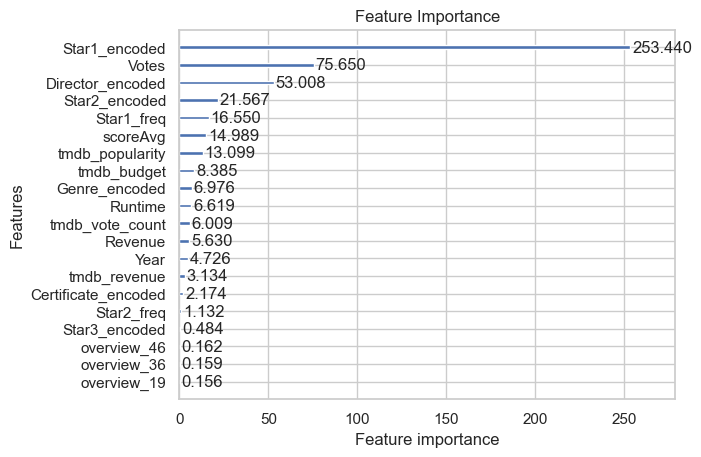

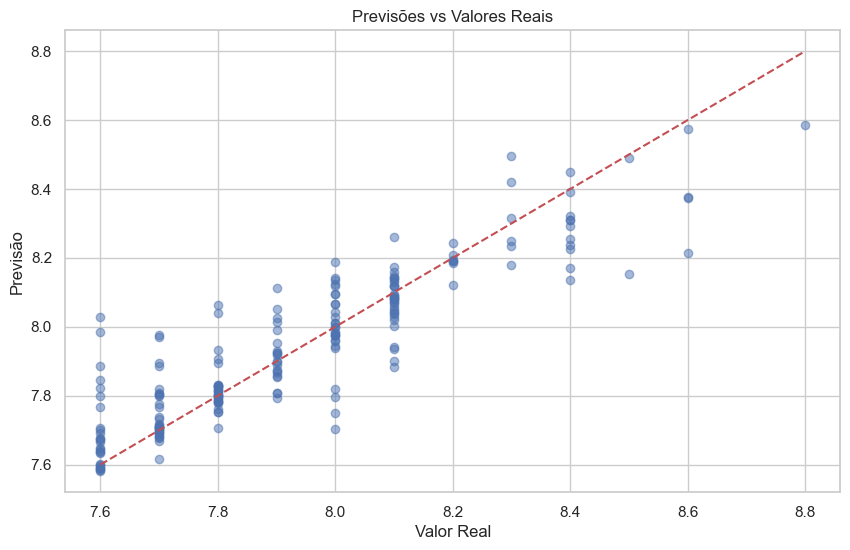

['../models/lgmb_principal_model.pkl']

In [193]:


# divide x e y 
X = df_encoded.drop('Rating', axis=1)
y = df_encoded['Rating']

# dividino em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# criando dataset do LightGBM ( lida nativamente com valores nulos)
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test, reference=train_data)


params = {'objective': 'regression','metric': 'rmse','boosting_type': 'gbdt', 'num_leaves': 31,'learning_rate': 0.05,  'feature_fraction': 0.9,  'bagging_fraction': 0.8, 'bagging_freq': 5,'verbose': -1,'force_col_wise': True,'zero_as_missing': False }


model = lgbm.train( params, train_data,  num_boost_round=1000,  valid_sets=[test_data], callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(100)])


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# importância das features
plt.figure(figsize=(10, 12))
lgbm.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance')
plt.show()

# previsões vs valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valor Real')
plt.ylabel('Previsão')
plt.title('Previsões vs Valores Reais')
plt.show()
joblib.dump(model, "../models/lgmb_principal_model.pkl")

- Melhor iteração (Early Stopping): 126

- RMSE (Root Mean Squared Error): 0.1143

- MAE (Mean Absolute Error): 0.0768

- R² (Coeficiente de Determinação): 0.8009

Um RMSE reduzido aponta para estimativas bem alinhadas com os dados observados.

O MAE confirma que a magnitude média dos erros é igualmente modesta, denotando acurácia.

Um R² de 0.80 revela que o modelo justifica cerca de 80% da variação nas avaliações dos filmes.


#### Importancia das Features 

- A característica Star1_encoded se sobressai como a mais crucial, sinalizando que a presença do ator principal exerce uma influência considerável na avaliação do filme.

- A quantidade de votos também se mostra bastante relevante, o que demonstra que filmes com um número maior de votos geralmente exercem um efeito importante na previsão.

- Director_encoded e Star2_encoded surgem como fatores importantes, o que enfatiza que tanto o diretor quanto o segundo ator cooperam para o triunfo da crítica.

- Os atributos do resumo (TF-IDF) exibem uma importância individual menor, o que sugere que, ainda que o texto da sinopse seja útil, ele possui menos peso se comparado com dados estruturais, como o elenco e os votos.

- As variáveis numéricas, como scoreAvg, tmdb_popularity e tmdb_budget, apresentam uma influência moderada no resultado final.

#### Conclusão 

Ao avaliarmos como o modelo LightGBM se saiu ao estimar as avaliações do IMDb, notamos que ele teve um desempenho bem positivo. Considerando as projeções do IMDb, a produtora pProductions conseguirá escolher o perfil do filme que será mais rentável e promissior. Além disso a EDA nos forneceu insights interessantes sobre o comportamento das features cinematograficas.